In [1]:
import pandas as pd
from datetime import datetime
import networkx as nx
import itertools
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import copy

from distfit import distfit

In [2]:
with open("./graph_networkx_SOUTHAMERICA_msc_route.pkl", 'rb') as f:
    G_loaded = pickle.load(f)
    G = copy.deepcopy(G_loaded)

### Plot based on longitude, latitude

In [3]:
f = open("data_av/msc_route_country_port_codes.json")
dict_ports = json.load(f)

In [4]:
#Plot nodes based on location
for node, attributes in G.nodes(data=True):
    try:
        attributes["latitude"] = dict_ports[node]["LocationLatitude"]
        attributes["longitude"] = dict_ports[node]["LocationLongitude"]
    except KeyError:
        raise Warning("Port {0} cannot be found".format(node))
        
position_ports = {k: (attr["longitude"], attr["latitude"]) for k, attr in G.nodes(data=True)}

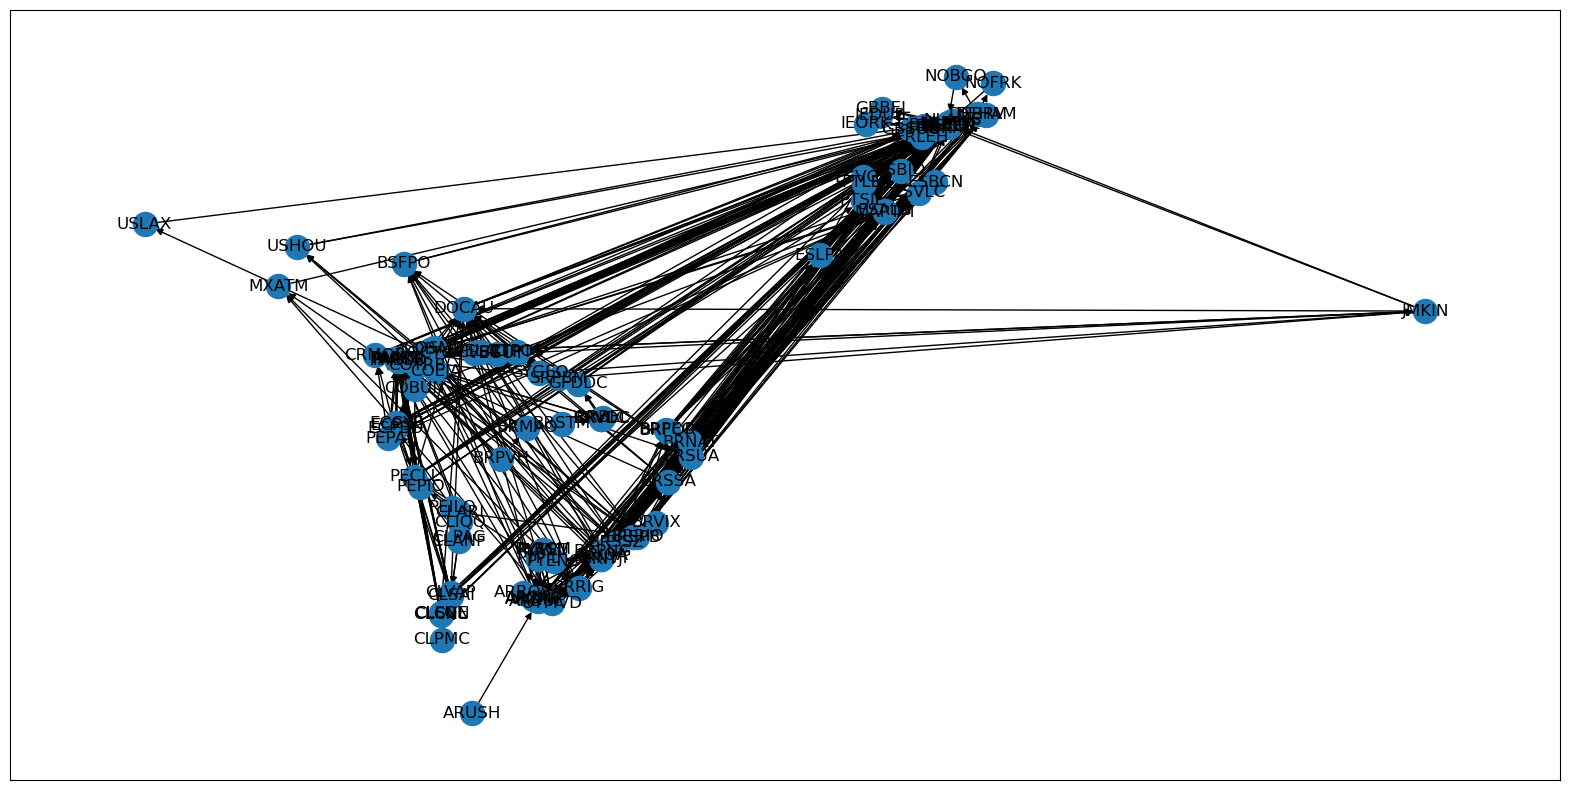

In [5]:
plt.figure(figsize=(20,10))
nx.draw_networkx(G, pos=position_ports)

# Create histogram of the edges

In [6]:
#Add frequency of the duplicates
for edge in G.edges(data=True):
    etd = edge[2]["etd_origin"]
    eta = edge[2]["eta_destination"]
    time = edge[2]["time_minutes"]
    
    combine = []
    for (o, d, t) in zip(etd, eta, time):
        combine.append((o, d, t))
        
    freq = {}
    for i in combine:
        freq[i] = combine.count(i)
        
    median_time_minutes = np.median([k[2] for k,v in freq.items()])

    G.edges[edge[0], edge[1]]["frequency"] = freq
    G.edges[edge[0], edge[1]]["median_time_minutes"] = median_time_minutes

In [7]:
# for edge in G.edges(data=True):
#     plt.figure(figsize=(4,4))
#     plt.title(edge[0] + " to " + edge[1])
#     plt.ylabel("Frequency")
#     plt.xlabel("Days")
# #     plt.hist([k/60/24 for k in edge[2]["time_minutes"]])
#     plt.hist([k[2]/60/24 for k, v in edge[2]["frequency"].items()])

# Fit distributions on histograms

We will use *distfit*. Advantages are that it calculates the KS correctly and is faster. Disadvantages are that it only gives plot results of the best fitted distribution, and only one statistic for determining the fit is calculated per comparison (we can do multiple).

In [8]:
dist_to_fit = ["expon", "beta", "uniform", "triang"]

In [9]:
for edge in G.edges(data=True):
    
    data = np.array([k[2] for k, v in edge[2]["frequency"].items()]) #minutes (not days)
    unique_value, unique_count = np.unique(data, return_counts=True)
    n_obs = len(data)
    
    if len(unique_value) == 1:
        G.edges[edge[0], edge[1]]["distribution"] = {"deterministic": {"params": unique_value}}
    
    elif len(unique_value) > 1 and n_obs < 30:
        normalized_unique_count = [float(i)/sum(unique_count) for i in unique_count]
        G.edges[edge[0], edge[1]]["distribution"] = {"discrete": {"model": np.random.choice,
                                                                "params": (unique_value, normalized_unique_count)}}
        
    else:
        dfit_rss = distfit(distr=dist_to_fit, stats="RSS")
        dfit_ks = distfit(distr=dist_to_fit, stats="ks")

        results_rss = dfit_rss.fit_transform(data)
        results_ks = dfit_ks.fit_transform(data)

        G.edges[edge[0], edge[1]]["distribution_full"] = {"RSS": results_rss, "KS": results_ks}
        G.edges[edge[0], edge[1]]["distribution"] = {"dist": {"model": results_rss["model"]["model"]}}
    

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 1.64614e-06] [loc=443.000 scale=202.980]
[distfit] >INFO> [beta   ] [0.20 sec] [RSS: 3.17599e-06] [loc=443.000 scale=1622.112]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 9.18113e-06] [loc=443.000 scale=1357.000]
[distfit] >INFO> [triang ] [0.28 sec] [RSS: 5.99904e-06] [loc=443.000 scale=1414.527]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 0.2402] [loc=443.000 scale=202.980]
[distfit] >INFO> [beta   ] [0.21 sec] [ks: 0.2402] [loc=443.000 scale=1622.112]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 1.27548] [loc=443.000 scale=1357.000]
[distfit] >INFO> [triang ] [0.27 sec] [ks: 0.673416] [loc=443.000 scale=1414.527]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 2.4824e-07] [loc=38940.000 sc

[distfit] >INFO> [triang ] [0.27 sec] [RSS: 3.7589e-05] [loc=267.484 scale=1222.919]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 2.20109] [loc=270.000 scale=91.524]
[distfit] >INFO> [beta   ] [0.23 sec] [ks: 2.20109] [loc=270.000 scale=11874.639]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 3.13051] [loc=270.000 scale=1170.000]
[distfit] >INFO> [triang ] [0.45 sec] [ks: 2.20109] [loc=267.484 scale=1222.919]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 2.80284e-07] [loc=44520.000 scale=7724.870]
[distfit] >INFO> [beta   ] [0.06 sec] [RSS: 9.92112e-08] [loc=-110678.684 scale=166331.640]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 2.10141e-07] [loc=44520.000 scale=10680.000]
[distfit] >INFO> [triang ] [0.34 sec] [RSS: 1.2862e-07] [loc=44386.800 scale=10942.143]
[distfit] >INFO> Comp

[distfit] >INFO> [beta   ] [0.20 sec] [ks: 1.06036] [loc=17340.000 scale=80905.216]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 2.60443] [loc=17340.000 scale=6540.000]
[distfit] >INFO> [triang ] [0.42 sec] [ks: 1.72937] [loc=17339.990 scale=6709.440]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 4.57087e-06] [loc=17940.000 scale=3560.801]
[distfit] >INFO> [beta   ] [0.08 sec] [RSS: 3.20259e-06] [loc=-113338.435 scale=855109.386]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 4.29175e-06] [loc=17940.000 scale=7100.000]
[distfit] >INFO> [triang ] [0.38 sec] [RSS: 3.65237e-06] [loc=17926.621 scale=7130.940]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 8.185] [loc=17940.000 scale=3560.801]
[distfit] >INFO> [beta   ] [0.10 sec] [ks: 0.869655] [loc=-113338.435 scale=855109.386]
[distfit] >

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 15.4619] [loc=363.000 scale=0.029]
[distfit] >INFO> [beta   ] [0.18 sec] [RSS: 43.4225] [loc=363.000 scale=10.508]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 39.28] [loc=363.000 scale=1.000]
[distfit] >INFO> [triang ] [0.38 sec] [RSS: 42.7552] [loc=362.029 scale=1.971]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 1.27548] [loc=363.000 scale=0.029]
[distfit] >INFO> [beta   ] [0.18 sec] [ks: 1.27548] [loc=363.000 scale=10.508]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 2.08839] [loc=363.000 scale=1.000]
[distfit] >INFO> [triang ] [0.37 sec] [ks: 2.08839] [loc=362.029 scale=1.971]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 3.2291] [loc=190.000 scale=0.062]
[distfit] >INFO> [beta   ] [0.18

[distfit] >INFO> [triang ] [0.49 sec] [RSS: 9.95391e-08] [loc=31379.206 scale=11340.795]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 0.548716] [loc=32415.000 scale=6370.909]
[distfit] >INFO> [beta   ] [0.30 sec] [ks: 1.06036] [loc=32382.191 scale=10337.809]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 1.72937] [loc=32415.000 scale=10305.000]
[distfit] >INFO> [triang ] [0.52 sec] [ks: 0.548716] [loc=31379.206 scale=11340.795]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 1.29964e-07] [loc=27000.000 scale=5402.500]
[distfit] >INFO> [beta   ] [0.22 sec] [RSS: 5.67626e-08] [loc=26903.702 scale=8736.298]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 7.64304e-08] [loc=27000.000 scale=8640.000]
[distfit] >INFO> [triang ] [0.45 sec] [RSS: 5.45831e-08] [loc=26358.108 scale=9282.744]
[distfit

[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 0.00459765] [loc=40800.000 scale=10498.741]
[distfit] >INFO> [beta   ] [0.22 sec] [ks: 0.00459765] [loc=40499.173 scale=18735.827]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 0.900064] [loc=40800.000 scale=18435.000]
[distfit] >INFO> [triang ] [0.32 sec] [ks: 0.00459765] [loc=38135.393 scale=21257.803]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 1.42368e-06] [loc=936.000 scale=915.866]
[distfit] >INFO> [beta   ] [0.20 sec] [RSS: 1.71616e-06] [loc=936.000 scale=864250.027]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 1.92507e-06] [loc=936.000 scale=4404.000]
[distfit] >INFO> [triang ] [0.37 sec] [RSS: 1.49136e-06] [loc=922.762 scale=4497.768]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO

[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 0.00459765] [loc=1140.000 scale=1838.535]
[distfit] >INFO> [beta   ] [0.17 sec] [ks: 1.47409] [loc=1140.000 scale=3618.740]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 2.20109] [loc=1140.000 scale=3600.000]
[distfit] >INFO> [triang ] [0.27 sec] [ks: 0.136611] [loc=598.668 scale=4178.410]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 4.69809e-07] [loc=19915.000 scale=2789.866]
[distfit] >INFO> [beta   ] [0.19 sec] [RSS: 2.98641e-07] [loc=19596.100 scale=29870892724825688.000]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 4.84567e-07] [loc=19915.000 scale=11765.000]
[distfit] >INFO> [triang ] [0.31 sec] [RSS: 3.77075e-07] [loc=19785.537 scale=12069.454]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 1.22893] [loc=1991

[distfit] >INFO> [beta   ] [0.20 sec] [ks: 0.180364] [loc=-5357.965 scale=1266186650.129]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 2.60443] [loc=4140.000 scale=14280.000]
[distfit] >INFO> [triang ] [0.30 sec] [ks: 1.72937] [loc=3925.495 scale=14692.103]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 1.36612e-07] [loc=3660.000 scale=6606.947]
[distfit] >INFO> [beta   ] [0.22 sec] [RSS: 8.01093e-08] [loc=-38352.520 scale=1186225.516]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 1.23262e-07] [loc=3660.000 scale=13680.000]
[distfit] >INFO> [triang ] [0.69 sec] [RSS: 9.23155e-08] [loc=3272.797 scale=14283.647]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 0.548716] [loc=3660.000 scale=6606.947]
[distfit] >INFO> [beta   ] [0.26 sec] [ks: 0.180364] [loc=-38352.520 scale=1186225.516]
[dis

In [37]:
results_rss["model"]["model"].rvs()

3935.7000045776367

In [10]:
for edge in G.edges(data=True):
    print(edge[0], edge[1])
    try:
        print("RSS:", edge[2]["distribution_full"]["RSS"]["model"]["name"], edge[2]["distribution_full"]["RSS"]["model"]["score"])
        print("KS:", edge[2]["distribution_full"]["KS"]["model"]["name"], edge[2]["distribution_full"]["KS"]["model"]["score"])
    except KeyError:
        try:
            print("Deterministic with parameter", edge[2]["distribution"]["deterministic"]["params"][0], "minutes")
        except KeyError:
            print("Discrete with parameters", edge[2]["distribution"]["discrete"]["params"])

ARBUE BRSSA
Deterministic with parameter 11790 minutes
ARBUE DEBRV
Discrete with parameters (array([50880, 51840, 52140, 52200]), [0.2, 0.4, 0.2, 0.2])
ARBUE BSFPO
Discrete with parameters (array([38760, 42420]), [0.5, 0.5])
ARBUE DOCAU
Discrete with parameters (array([34380, 34620, 37470, 38040]), [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.5])
ARBUE PACTB
Discrete with parameters (array([30225, 30345, 33195, 33720, 33765, 34425]), [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666])
ARBUE BRITJ
Discrete with parameters (array([6000, 6279, 6720, 7920]), [0.25, 0.25, 0.25, 0.25])
ARBUE UYMVD
RSS: expon 1.6461427792492548e-06
KS: expon 0.2402001308430499
ARBUE NLRTM
RSS: beta 1.3725892467513117e-07
KS: expon 0.548715852176922
ARBUE DEHAM
Discrete with parameters (array([42600, 48540, 49500, 49800, 49860]), [0.16666666666666666, 0.16666666666666666, 0.3333333333333333, 0.16666666666666666, 0.

## Also for processing times at the transit ports

In [11]:
# Make a list of all processing times -- there are no double routes so we do not have to find the unique once
for node, attr in G.nodes(data=True):
    processing_times = []
    
    for k, v in attr.items():
        try:
            if "ProcessingTimeMinutes" in v:
                processing_times.append(v["ProcessingTimeMinutes"])
            else:
                continue
        except TypeError:
            continue

    if len(processing_times) == 0:
        continue
    else:
        G.nodes[node]["all_processing_times_minutes"] = processing_times

In [12]:
dist_to_fit = ["expon", "beta", "uniform", "triang"]

In [13]:
for node, attr in G.nodes(data=True):
    
    if "all_processing_times_minutes" in attr:
    
        data = np.array(attr["all_processing_times_minutes"]) #minutes (not days)
        unique_value, unique_count = np.unique(data, return_counts=True)
        n_obs = len(data)

        if len(unique_value) == 1:
            if unique_value == 0:
                continue
            else:
                G.nodes[node]["processing_distribution"] = {"deterministic": {"params": unique_value}}

        elif len(unique_value) > 1 and n_obs < 30:
            normalized_unique_count = [float(i)/sum(unique_count) for i in unique_count]
            G.nodes[node]["processing_distribution"] = {"discrete": {"model": np.random.choice,
                                                                    "params": (unique_value, normalized_unique_count)}}

        else:
            dfit_rss = distfit(distr=dist_to_fit, stats="RSS")
            dfit_ks = distfit(distr=dist_to_fit, stats="ks")

            results_rss = dfit_rss.fit_transform(data)
            results_ks = dfit_ks.fit_transform(data)

            G.nodes[node]["processing_distribution_full"] = {"RSS": results_rss, "KS": results_ks}
            G.nodes[node]["processing_distribution"] = {"dist": {"model": results_rss["model"]["model"]}}
    else:
        continue

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 4.25018e-07] [loc=-57960.000 scale=51407.782]
[distfit] >INFO> [beta   ] [0.20 sec] [RSS: 4.30489e-07] [loc=-57987.135 scale=71367.135]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 4.15628e-07] [loc=-57960.000 scale=71340.000]
[distfit] >INFO> [triang ] [0.43 sec] [RSS: 4.04065e-07] [loc=-64152.884 scale=78204.731]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 28.2512] [loc=-57960.000 scale=51407.782]
[distfit] >INFO> [beta   ] [0.19 sec] [ks: 22.226] [loc=-57987.135 scale=71367.135]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 40.6249] [loc=-57960.000 scale=71340.000]
[distfit] >INFO> [triang ] [0.52 sec] [ks: 22.226] [loc=-64152.884 scale=78204.731]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [R

[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 1.19731e-07] [loc=870.000 scale=5949.861]
[distfit] >INFO> [beta   ] [0.18 sec] [RSS: 9.40947e-08] [loc=-189.192 scale=11709.192]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 8.27814e-08] [loc=870.000 scale=10650.000]
[distfit] >INFO> [triang ] [0.23 sec] [RSS: 7.63635e-08] [loc=-222.580 scale=12211.624]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 0.00126267] [loc=870.000 scale=5949.861]
[distfit] >INFO> [beta   ] [0.15 sec] [ks: 0.674739] [loc=-189.192 scale=11709.192]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 1.68321] [loc=870.000 scale=10650.000]
[distfit] >INFO> [triang ] [0.23 sec] [ks: 0.319528] [loc=-222.580 scale=12211.624]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 6.15919e-06] [loc=188.000 scale=2788.281]
[distfit] >INFO> 

[distfit] >INFO> [uniform] [0.00 sec] [RSS: 9.42245e-09] [loc=-38100.000 scale=52297.000]
[distfit] >INFO> [triang ] [0.47 sec] [RSS: 5.41598e-09] [loc=-38243.345 scale=52873.800]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 0.4643] [loc=-38100.000 scale=11594.062]
[distfit] >INFO> [beta   ] [0.17 sec] [ks: 0.196895] [loc=-38127.151 scale=337726.429]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 2.99107] [loc=-38100.000 scale=52297.000]
[distfit] >INFO> [triang ] [0.47 sec] [ks: 1.22893] [loc=-38243.345 scale=52873.800]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 4.61271e-06] [loc=0.000 scale=4142.471]
[distfit] >INFO> [beta   ] [0.16 sec] [RSS: 7.27472e-07] [loc=-32437.863 scale=36817.863]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 4.27972e-06] [loc=0.000 scale=4380.000]
[distfi

[distfit] >INFO> [triang ] [0.39 sec] [RSS: 1.36422e-07] [loc=-64304.852 scale=66699.278]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 9.4149] [loc=-44145.000 scale=16897.807]
[distfit] >INFO> [beta   ] [0.17 sec] [ks: 7.15841] [loc=-44158.409 scale=46198.409]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 12.1511] [loc=-44145.000 scale=46185.000]
[distfit] >INFO> [triang ] [0.41 sec] [ks: 11.1767] [loc=-64304.852 scale=66699.278]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 2.2296e-07] [loc=2160.000 scale=2769.293]
[distfit] >INFO> [beta   ] [0.21 sec] [RSS: 1.48028e-07] [loc=2117.083 scale=1348683034.865]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 3.2384e-07] [loc=2160.000 scale=11405.000]
[distfit] >INFO> [triang ] [0.33 sec] [RSS: 1.95263e-07] [loc=2130.823 scale=11479.058]
[di

[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [ks: 1.47409] [loc=0.000 scale=2075.233]
[distfit] >INFO> [beta   ] [0.25 sec] [ks: 1.47409] [loc=-0.000 scale=11755.698]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 2.20109] [loc=0.000 scale=11100.000]
[distfit] >INFO> [triang ] [0.47 sec] [ks: 2.20109] [loc=-0.051 scale=13576.927]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 2.81825e-07] [loc=2872.917 scale=5653.764]
[distfit] >INFO> [beta   ] [0.14 sec] [RSS: 2.03442e-07] [loc=1388.623 scale=10491.377]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 2.1074e-07] [loc=2872.917 scale=9007.083]
[distfit] >INFO> [triang ] [0.25 sec] [RSS: 1.29668e-07] [loc=2222.292 scale=9852.975]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] 

[distfit] >INFO> [expon  ] [0.00 sec] [ks: 0.180364] [loc=4218.000 scale=2070.000]
[distfit] >INFO> [beta   ] [0.21 sec] [ks: 0.180364] [loc=4218.000 scale=7564.515]
[distfit] >INFO> [uniform] [0.00 sec] [ks: 1.06036] [loc=4218.000 scale=7362.000]
[distfit] >INFO> [triang ] [0.27 sec] [ks: 0.180364] [loc=4218.000 scale=7630.218]
[distfit] >INFO> Compute confidence intervals [parametric]


In [14]:
for node, attr in G.nodes(data=True):
    print(node)
    try:
        print("RSS:", attr["processing_distribution_full"]["RSS"]["model"]["name"], attr["processing_distribution_full"]["RSS"]["model"]["score"])
        print("KS:", attr["processing_distribution_full"]["KS"]["model"]["name"], attr["processing_distribution_full"]["KS"]["model"]["score"])
    except KeyError:
        try:
            print("Deterministic with parameter", attr["processing_distribution"]["deterministic"]["params"][0], "minutes")
        except KeyError:
            try:
                print("Discrete with parameters", attr["processing_distribution"]["discrete"]["params"])
            except KeyError:
                print("No processing time")
            

ARBUE
RSS: triang 4.040654767467231e-07
KS: beta 22.22600189913783
BRRIO
RSS: triang 2.3984218523827958e-09
KS: expon 0.3195281770484577
BEANR
RSS: beta 8.928600591231223e-06
KS: expon 5.736221858249673
UYMVD
RSS: beta 1.5586659947966354e-07
KS: beta 10.670696372502327
NLRTM
RSS: beta 9.153114058769561e-07
KS: expon 0.42949853534704535
GBLGP
RSS: beta 1.028224829752881e-07
KS: beta 0.2431084063414785
DEBRV
RSS: beta 6.817011258028006e-07
KS: expon 0.3702913286790437
PACTB
RSS: beta 1.181026674159097e-07
KS: beta 0.08436091112660024
BRRIG
RSS: triang 1.8862948908105675e-08
KS: expon 1.5025719434320897
MAPTM
RSS: triang 7.636349336486489e-08
KS: expon 0.0012626712437568415
PTLEI
RSS: beta 5.7171264983499416e-06
KS: expon 22.72908007091475
DEHAM
RSS: triang 3.7390855213247117e-07
KS: expon 0.23047788477435355
ESLPA
RSS: triang 1.7774514653548043e-08
KS: beta 0.01632540413647903
IEORK
RSS: beta 2.1733437038784574e-07
KS: expon 0.905547954184143
ESVLC
RSS: triang 8.568893974081998e-08
KS: e

### Save to pkl

In [15]:
with open("./graph_networkx_SOUTHAMERICA_msc_route_with_distributions.pkl", "wb") as f:
    pickle.dump(G, f)

In [16]:
# nx.write_gpickle(G, "./graph_networkx_SOUTHAMERICA_msc_route_with_distributions.gpickle")

# Additional Code

In [48]:
#dfit.plot_summary()

[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Loggamma(loc:0.500000, scale:0.000000)


(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\nloggamma(c=1.57368e-08, loc=0.5, scale=1.88086e-11)'}, xlabel='Values', ylabel='Frequency'>)

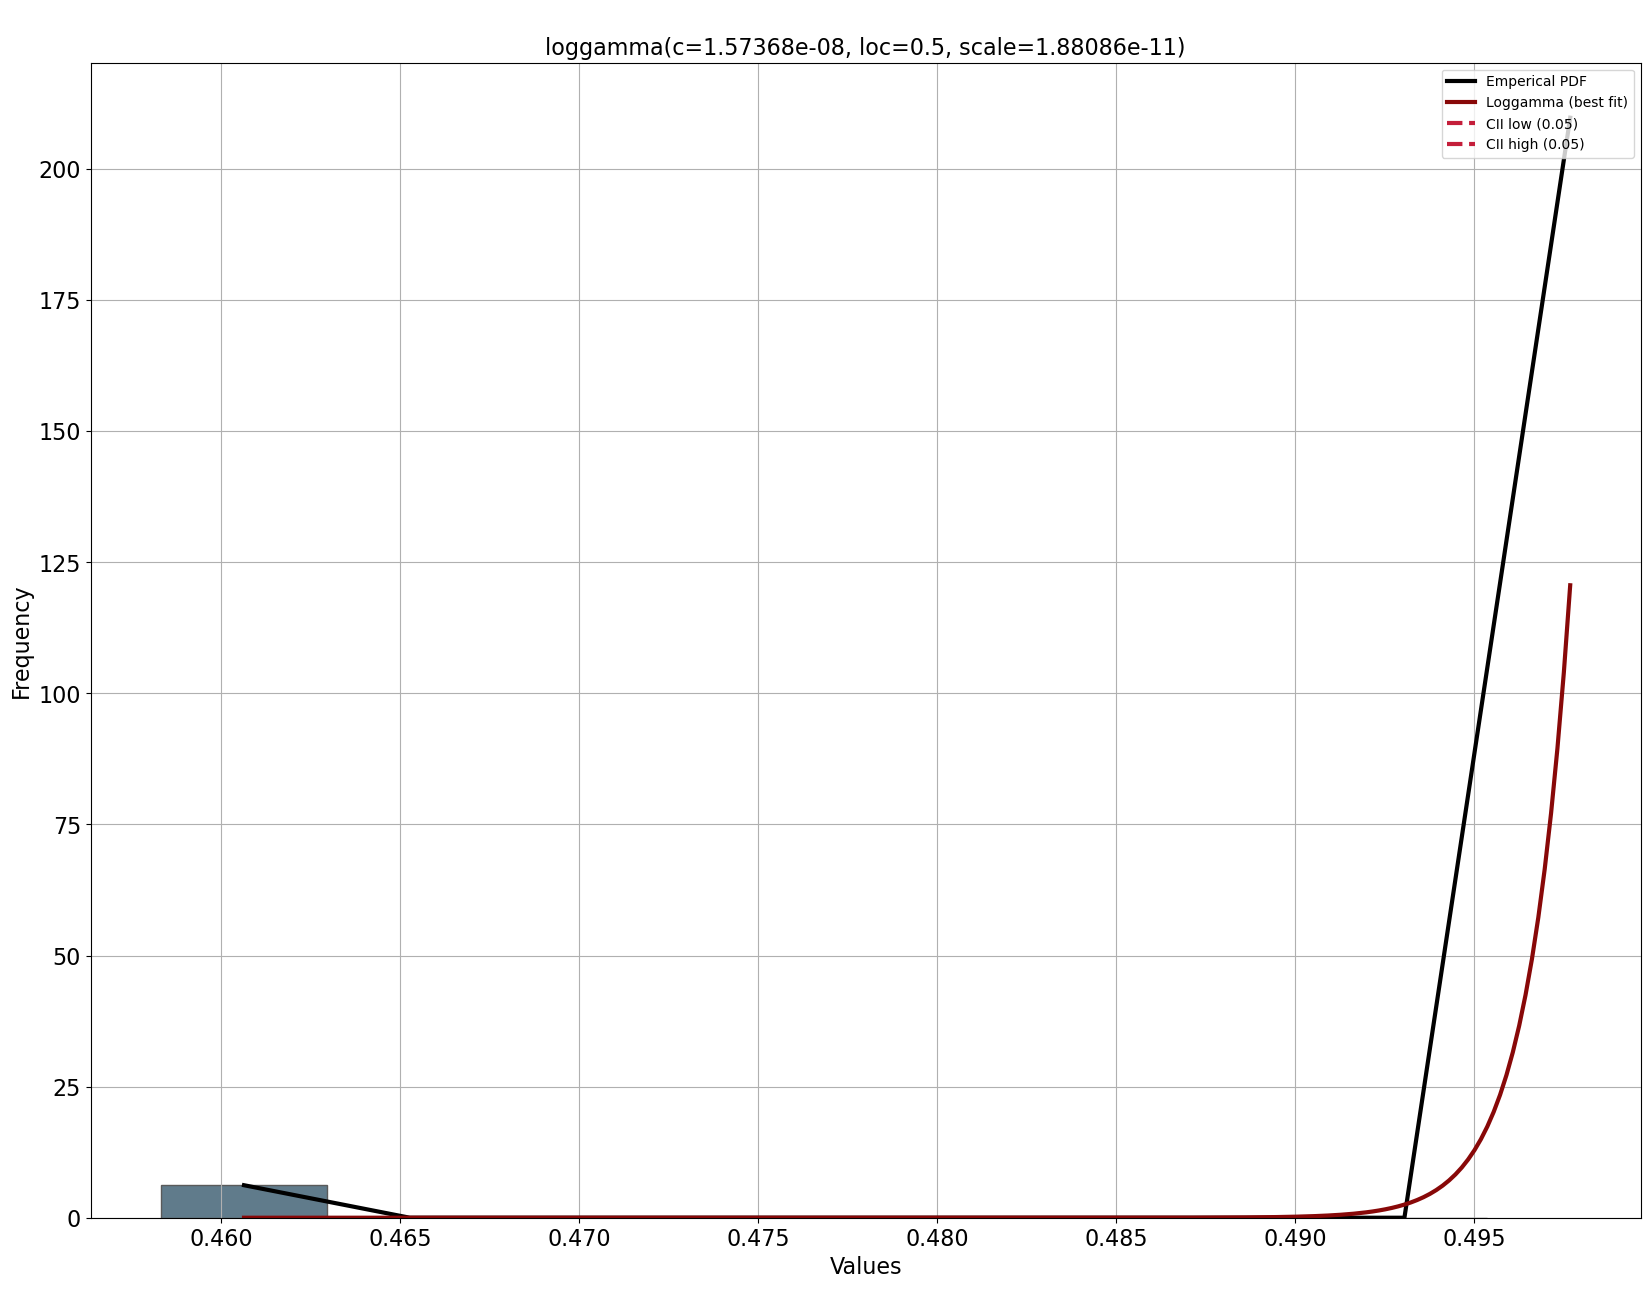

In [123]:
#RSS
dfit.plot()

[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:0.498804, scale:0.006958)


(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\nnorm(loc=0.498804, scale=0.00695771)'}, xlabel='Values', ylabel='Frequency'>)

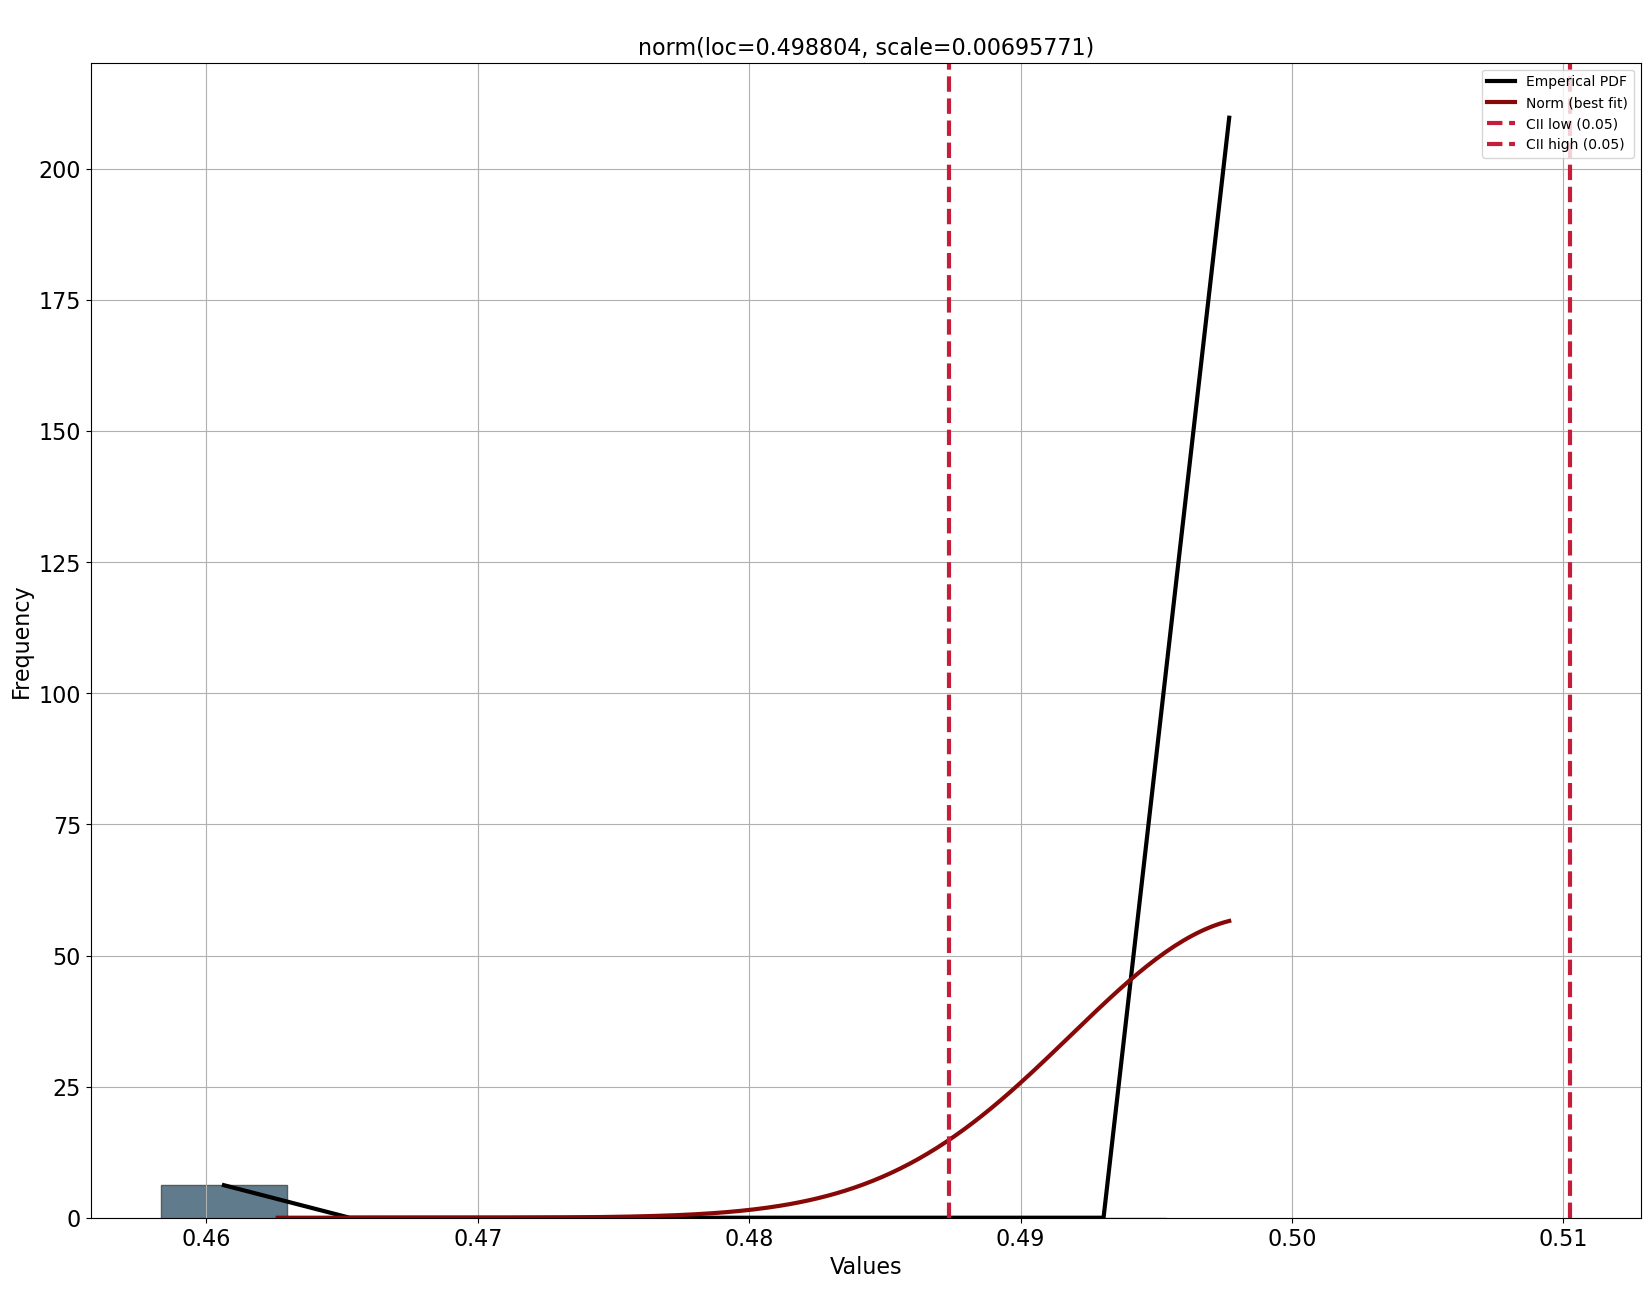

In [125]:
#KS
dfit_ks.plot()

In [119]:
dfit_ks.summary

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,anglit,0.004598,1.859347,0.0,(),"(1.8593472450961737, 1.9536694276089068e-29)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,cosine,0.004598,5.393639,0.0,(),"(5.393638980384704, 4.884173569022267e-30)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,pearson3,0.004598,0.5,0.0,"(1.5033668730548078,)","(1.5033668730548078, 0.5, 2.3021587801744147e-27)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
3,rdist,0.004598,1.755207,0.0,"(1.3053444384788429,)","(1.3053444384788429, 1.755207104796819, 6.4179...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
4,semicircular,0.004598,2.179885,0.0,(),"(2.1798854248578436, 4.5505304156063075e-31)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
...,...,...,...,...,...,...,...,...,...,...
75,truncexpon,3.130512,0.458333,0.047161,"(0.8834906906757068,)","(0.8834906906757068, 0.45833332966395646, 0.04...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
76,truncnorm,3.130512,-0.004374,1.010158,"(0.4580541486160743, 0.49930182424312397)","(0.4580541486160743, 0.49930182424312397, -0.0...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
77,uniform,3.130512,0.458333,0.041667,(),"(0.4583333333333333, 0.041666666666666685)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
78,logistic,4.385785,0.499929,-0.001196,(),"(0.4999292697090617, -0.0011961722487895253)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
